In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.model.mpra_basset import MPRA_Basset
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print('')

archive unpacked in ./


Loaded model from 20211113_021200 in eval mode



In [96]:
class IntegratedSampledGradients(nn.Module):
    def __init__(self,
                 target_distributions,
                 predictor,
                 baseline=None,
                 num_samples=1,
                 batch_dim=0,
                 token_dim=-2,
                 cat_dim=-1):
        super().__init__()
        self.predictor = predictor  
        self.baseline = baseline
        self.num_samples = num_samples
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.cat_dim = cat_dim
        
        self.register_buffer('target_distributions', target_distributions)
        self.target_distributions.requires_grad_()       
        self.grad = torch.autograd.grad
        
        self.num_classes = self.target_distributions.shape[self.token_dim]
        self.batch_size = self.target_distributions.shape[self.batch_dim]
        self.n_dims = len(self.target_distributions.shape)
        self.repeater = [ 1 for i in range(self.n_dims) ]

        if self.baseline == None:
            base_distribution = 0.25 * torch.ones_like(self.target_distributions)
            self.register_buffer('base_distribution', base_distribution)
        else:
            self.register_buffer('base_distribution', baseline.view(self.target_distributions.shape))
        self.base_distribution.requires_grad_()
        
    def rebatch(self, input):
        return input.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

    def get_samples(self, distribution):
        nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
        multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, distributions):
        samples = self.get_samples(distributions).flatten(0,1)
        predictions = self.rebatch(self.predictor(samples))
        gradients = torch.autograd.grad(predictions.sum(), inputs=distributions, retain_graph=True)[0]
        return gradients, predictions

    def get_point_distribution(self, k):
        return self.base_distribution + k * (self.target_distributions - self.base_distribution)

    def integrate_gradients(self, num_steps=10, num_samples=20):
        self.num_samples = num_samples
        line_gradients = []
        #for i in tqdm(range(num_steps + 1)):
        for i in range(0, num_steps + 1):
            slope = i / num_steps
            point_distribution = self.get_point_distribution(slope)
            point_gradients, point_predictions = self.get_gradients(point_distribution)
            line_gradients.append(point_gradients)
            if i == 0:
                self.base_predictions = point_predictions.detach()
            elif i == num_steps:
                self.target_predictions = point_predictions.detach()
        return torch.stack(line_gradients).mean(dim=0)
    
    def get_salient_maps(self, num_steps=10, num_samples=20):
        #self.num_samples = num_samples
        gradients = self.integrate_gradients(num_steps=num_steps, num_samples=num_samples).to(self.target_distributions.device)        
        salient_maps =  gradients * self.target_distributions
        return salient_maps.detach()

# class IntegratedSampledGradients(nn.Module):
#     def __init__(self,
#                  target_distributions,
#                  predictor,
#                  baseline=None,
#                  num_samples=1,
#                  batch_dim=0,
#                  token_dim=-2,
#                  cat_dim=-1):
#         super().__init__()
#         self.predictor = predictor  
#         self.baseline = baseline
#         self.num_samples = num_samples
#         self.batch_dim = batch_dim
#         self.token_dim = token_dim
#         self.cat_dim = cat_dim
        
#         self.register_buffer('target_distributions', target_distributions)
#         self.target_distributions.requires_grad_()       
#         self.grad = torch.autograd.grad
        
#         self.num_classes = self.target_distributions.shape[self.token_dim]
#         self.batch_size = self.target_distributions.shape[self.batch_dim]
#         self.n_dims = len(self.target_distributions.shape)
#         self.repeater = [ 1 for i in range(self.n_dims) ]

#         if self.baseline == None:
#             base_distribution = 0.25 * torch.ones_like(self.target_distributions)
#             self.register_buffer('base_distribution', base_distribution)
#         else:
#             self.register_buffer('base_distribution', baseline.view(self.target_distributions.shape))
#         self.base_distribution.requires_grad_()
        
#     def rebatch(self, input):
#         return input.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

#     def get_samples(self, distribution):
#         nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
#         sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
#         sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
#         sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
#         multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
#         sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
#         return sampled_nucleotides

#     def get_gradients(self, distributions):
#         samples = self.get_samples(distributions).flatten(0,1)
#         predictions = self.rebatch(self.predictor(samples))
#         gradients = torch.autograd.grad(predictions.sum(), inputs=distributions, retain_graph=True)[0]
#         return gradients, predictions

#     def get_point_distribution(self, k):
#         return self.base_distribution + k * (self.target_distributions - self.base_distribution)

#     def integrate_gradients(self, num_steps=10, num_samples=20):
#         self.num_samples = num_samples
#         line_gradients = []
#         for i in range(1, num_steps + 1):
#             slope = i / num_steps
#             point_distribution = self.get_point_distribution(slope)
#             point_gradients, point_predictions = self.get_gradients(point_distribution)
#             line_gradients.append(point_gradients)
#             if i == 1:
#                 self.base_predictions = point_predictions.detach()
#             elif i == num_steps:
#                 self.target_predictions = point_predictions.detach()
#         return torch.stack(line_gradients).mean(dim=0)
    
#     def get_salient_maps(self, num_steps=10, num_samples=20):
#         #self.num_samples = num_samples
#         gradients = self.integrate_gradients(num_steps=num_steps, num_samples=num_samples).to(self.target_distributions.device)        
#         salient_maps =  gradients * self.target_distributions
#         return salient_maps.detach()

In [4]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis       
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 
        
class mpra_predictor_no_flanks(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx       
        
        try: self.model.eval()
        except: pass
            
    def forward(self, x):
        return self.model(x)[:, self.pred_idx] 

## Test set UKBB + GTEX +BODA30k

In [5]:
#for fixed-length sequences
def df_to_onehot_tensor(in_df, seq_column='sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

#for variable-length sequences
def get_onehots(in_df, seq_column='nt_sequence', extra_str=''):
    padding_fn = partial(utils.row_pad_sequence,
                            in_column_name=seq_column,
                            padded_seq_len=600)    
    print('Padding sequences' + extra_str)
    sequence_list = list(in_df.progress_apply(padding_fn, axis=1))     
    print('Tokenizing sequences' + extra_str)
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) for subsequence in tqdm(sequence_list)])
    return onehot_sequences

def get_predictions(onehot_sequences, model, eval_batch_size = 128, num_workers=2, extra_str=''):
    temp_dataset = TensorDataset(onehot_sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)
    print('Getting predictions' + extra_str)  
    preds = []
    for local_batch in tqdm(temp_dataloader):
        preds.append(model(local_batch[0].cuda()).cpu().detach().numpy())       
    preds_array = np.concatenate(preds, axis=0)  
    return preds_array

def entropy(X):
    p_c = F.softmax(torch.tensor(X, dtype=torch.float32), dim=1).numpy()
    return np.sum(- p_c * np.log(p_c), axis=1)

def append_predictions(dfs, model_paths, model_nicknames=None):
    activity_columns = ['K562_mean', 'HepG2_mean', 'SKNSH_mean']
    print('------------- Getting input tensors for each df -------------')
    print('')
    onehot_inputs = [get_onehots(df) for df in dfs]    
    if model_nicknames is None:
        model_nicknames = [str(i) for i in range(1, len(model_paths)+1)]
    assert len(model_nicknames) == len(model_paths)
    if os.path.isdir('./artifacts'):
        shutil.rmtree('./artifacts')
    prediction_columns_dict = {}
    for model_idx, model_path in enumerate(model_paths):
        unpack_artifact(model_path)
        model_dir = './artifacts'
        model = model_fn(model_dir)
        model.cuda()
        model.eval()
        model_nickname = model_nicknames[model_idx]
        prediction_columns = [activity_name.rstrip('mean') + 'pred_' \
                              + model_nickname for activity_name in activity_columns]
        prediction_columns_dict[model_nickname] = prediction_columns
        print('')
        print(f'------------- Getting model_{model_nickname} predictions for each df -------------')
        print('')
        for df_idx, df in enumerate(dfs):
            df[prediction_columns] = get_predictions(onehot_inputs[df_idx], model)
    return prediction_columns_dict

def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='True', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()    
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy() 
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = max(x_min, y_min), min(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)

In [6]:
main_df = pd.read_csv('gs://syrgoth/data/MPRA_ALL_no_cutoffs.txt', sep=" ", low_memory=False)

In [7]:
test_df = main_df[(main_df['chr'] == '7') | (main_df['chr'] == '13')].reset_index(drop=True)
test_df['seq_len'] = test_df.apply(lambda x: len(x['nt_sequence']), axis=1)

model_nicknames = ['relu']
model_paths = ['gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz']
# model_nicknames = ['relu', 'relu6']
# model_paths = ['gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz',
#                'gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz']

performance_dfs = [test_df]
prediction_columns_dict = append_predictions(performance_dfs, model_paths, model_nicknames=model_nicknames)

------------- Getting input tensors for each df -------------

Padding sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Tokenizing sequences


  0%|          | 0/66712 [00:00<?, ?it/s]

Loaded model from 20211113_021200 in eval mode

------------- Getting model_relu predictions for each df -------------

Getting predictions


archive unpacked in ./


  0%|          | 0/522 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
test_df_200 = test_df[test_df['seq_len'] == 200].reset_index(drop=True)
test_df_no_200 = test_df[test_df['seq_len'] != 200].reset_index(drop=True)

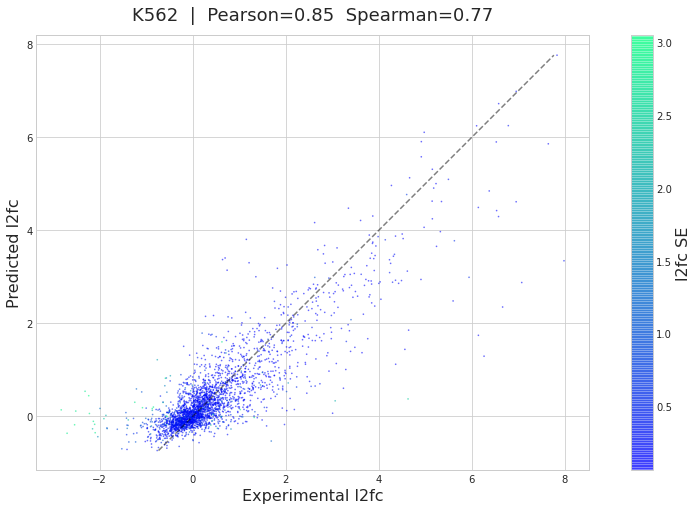

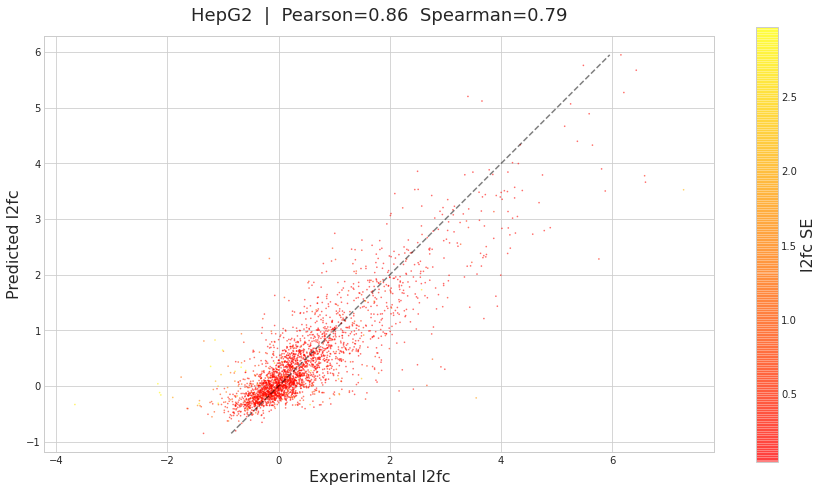

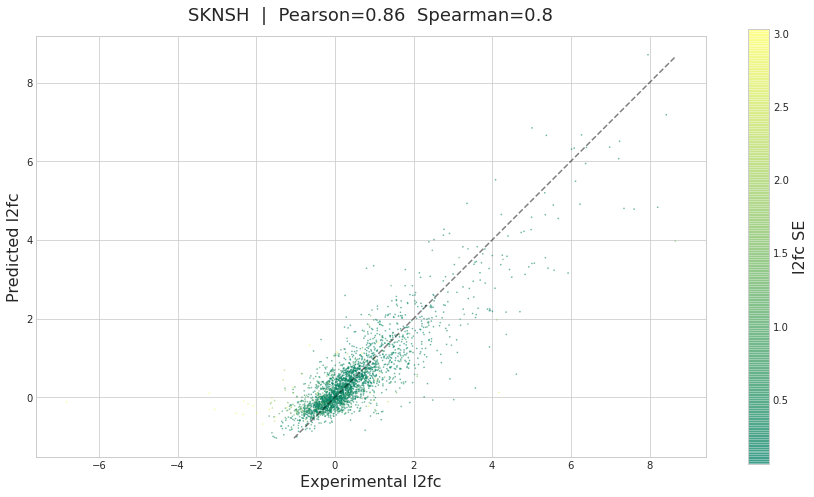

In [12]:
plot_df = test_df_no_200

activity_columns = ['K562_mean', 'HepG2_mean', 'SKNSH_mean']
coloring_columns = ['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']
colormaps = ['winter', 'autumn', 'summer']
for cell_idx, activity in enumerate(activity_columns):
    cell_name = activity.rstrip('_mean')
    pred_column_name =  cell_name + '_pred_' + 'relu'
    single_scatterplot(data_df=plot_df,
               x_axis=activity,
               y_axis=pred_column_name,
               color_axis=coloring_columns[cell_idx],
               fig_size=(15,8),
               dot_size=0.5,
               title=cell_name,
               dot_alpha=0.5,
               colormap=colormaps[cell_idx],
               x_label='Experimental l2fc',
               y_label='Predicted l2fc',
               color_label='l2fc SE')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
# single_scatterplot(data_df=plot_df,
#            x_axis='entropy',
#            y_axis='entropy_'+ 'relu',
#            color_axis='max_lfcSE',
#            fig_size=(15,8),
#            dot_size=0.5,
#            title='Entropy',
#            dot_alpha=0.5,
#            colormap='spring',
#            x_label='Experimental entropy',
#            y_label='Predicted entropy',
#            color_label='l2fc SE')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

In [86]:
small_test_df_200 = test_df_200.sample(n=500, random_state=123)

In [87]:
test_distributions = df_to_onehot_tensor(small_test_df_200, seq_column='nt_sequence')

  0%|          | 0/500 [00:00<?, ?it/s]

In [88]:
temp_dataset = TensorDataset(test_distributions)
temp_dataloader = DataLoader(temp_dataset, batch_size=50, shuffle=False, num_workers=2)

In [12]:
k562_predictor = mpra_predictor(model=model, pred_idx=0).cuda()
hepg2_predictor = mpra_predictor(model=model, pred_idx=1).cuda()
sknsh_predictor = mpra_predictor(model=model, pred_idx=2).cuda()

predictors = [k562_predictor, hepg2_predictor, sknsh_predictor]

In [97]:
%%time
all_base_predictions = []
all_target_predictions = []
all_salient_maps = []
# batch_idx = 1
# total_batches = len(temp_dataloader)
for local_batch in tqdm(temp_dataloader):
# for local_batch in temp_dataloader:
#     print(f'Batch {batch_idx} / {total_batches}')
    batch_distributions = local_batch[0]
    attributers = [IntegratedSampledGradients(batch_distributions, predictor).cuda() for predictor in predictors]
    salient_maps = []
    for idx, predictor in enumerate(predictors):
        salient_maps.append(attributers[idx].get_salient_maps(num_steps=50, num_samples=10).cpu())
    #all_salient_maps.append([attributer.get_salient_maps(num_steps=50, num_samples=10).cpu() for attributer in attributers])  
    all_base_predictions.append([attributer.base_predictions.cpu() for attributer in attributers])
    all_target_predictions.append([attributer.target_predictions.cpu() for attributer in attributers])
    all_salient_maps.append(salient_maps)
    #batch_idx +=1

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1min 16s, sys: 380 ms, total: 1min 17s
Wall time: 1min 16s


In [98]:
salient_map_tensor = torch.cat([torch.stack(salient_maps, dim=1) for salient_maps in all_salient_maps])

contribution_summations = salient_map_tensor.sum(dim=-1).sum(dim=-1).numpy()

true_deltas = small_test_df_200[['K562_mean', 'HepG2_mean', 'SKNSH_mean']].to_numpy()
predictesd_deltas = small_test_df_200[['K562_pred_relu', 'HepG2_pred_relu', 'SKNSH_pred_relu']].to_numpy()

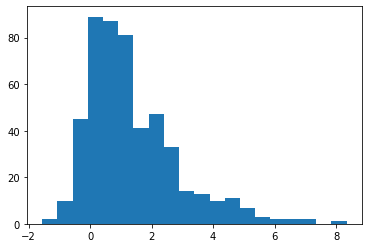

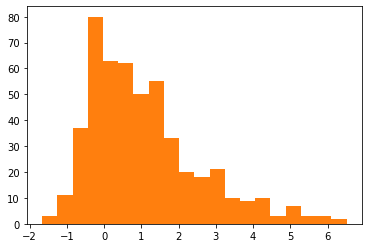

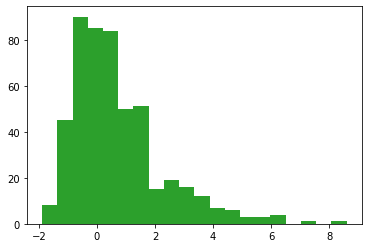

In [99]:
for cell_idx in range(3):
    plt.hist(contribution_summations[:,cell_idx], bins=20, color='C'+str(cell_idx))
    #plt.xlim(0,2)
    plt.show()

In [100]:
base_preds = torch.cat([torch.stack(base_predictions, dim=1) for base_predictions in all_base_predictions])
target_preds = torch.cat([torch.stack(target_predictions, dim=1) for target_predictions in all_target_predictions])

In [101]:
pred_diffs = (target_preds - base_preds).numpy()

0.7594066978784054
0.6957912951651807


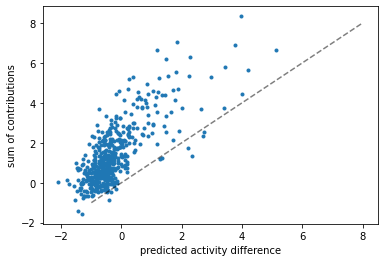

0.8250650215697424
0.7742918651674606


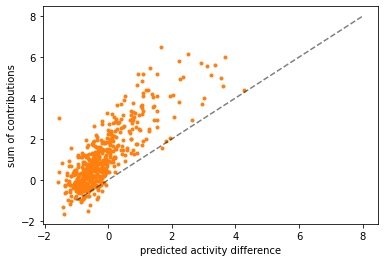

0.838305524755154
0.743817215268861


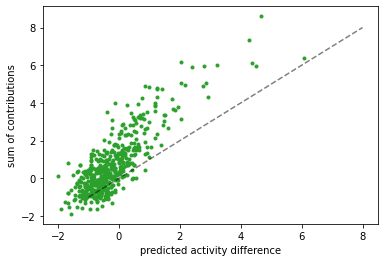

In [102]:
for cell_idx in range(3):

    print(stats.pearsonr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    print(stats.spearmanr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    plt.scatter(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
    plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
    plt.ylabel('sum of contributions')
    plt.xlabel('predicted activity difference')
    plt.show()

0.7533801585229662
0.6864309697238788


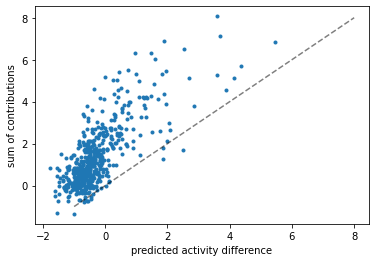

0.8100987304527714
0.7494442777771111


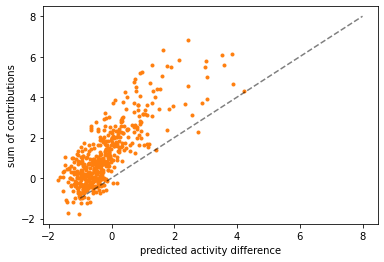

0.8227553887310147
0.7251313165252661


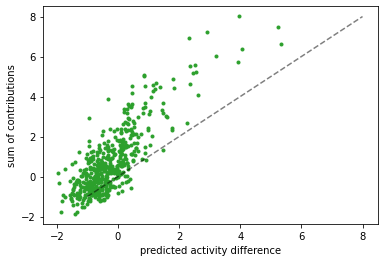

In [95]:
for cell_idx in range(3):

    print(stats.pearsonr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    print(stats.spearmanr(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx])[0])
    plt.scatter(pred_diffs[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
    plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
    plt.ylabel('sum of contributions')
    plt.xlabel('predicted activity difference')
    plt.show()

In [53]:
for cell_idx in range(3):
    print(stats.pearsonr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
    #print(stats.spearmanr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
    print('')

0.8428793929779462

0.8442912085196408

0.8706588492527885



0.843492251204156
0.8178374473497894


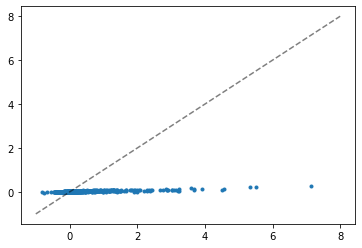

0.8596442035983599
0.8166675866703466


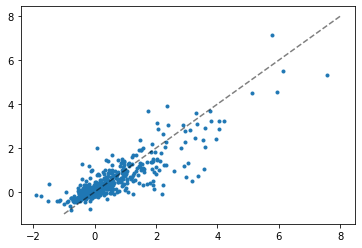

0.7385720071560575
0.682565610262441


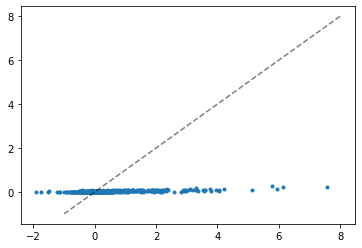

In [25]:
cell_idx = 0

print(stats.pearsonr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
print(stats.spearmanr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
plt.scatter(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

print(stats.pearsonr(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx])[0])
print(stats.spearmanr(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx])[0])
plt.scatter(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

print(stats.pearsonr(true_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
print(stats.spearmanr(true_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
plt.scatter(true_deltas[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

0.8442912085196408
0.8178043272173089


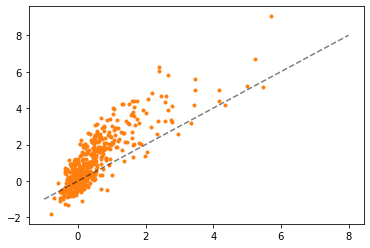

0.870713139641304
0.8038931035724142


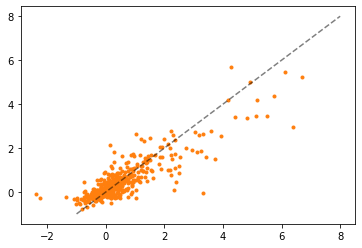

0.7069205571308189
0.6745562982251929


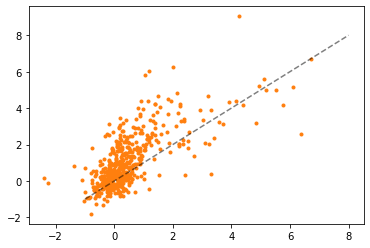

In [23]:
cell_idx = 1

print(stats.pearsonr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
print(stats.spearmanr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
plt.scatter(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

print(stats.pearsonr(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx])[0])
print(stats.spearmanr(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx])[0])
plt.scatter(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

print(stats.pearsonr(true_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
print(stats.spearmanr(true_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
plt.scatter(true_deltas[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

0.8706588492527885
0.8088230112920451


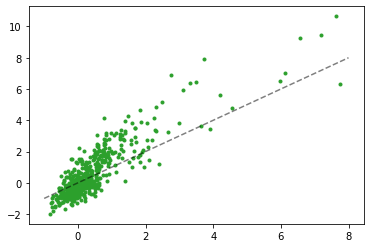

0.8813624931869246
0.8217791271165084


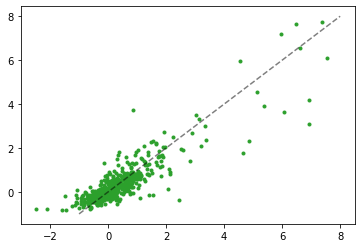

0.7510699875015344
0.6901684566738266


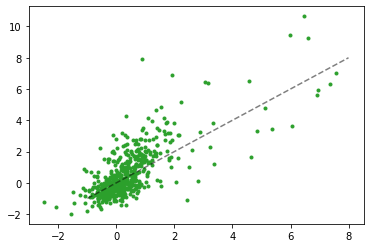

In [24]:
cell_idx = 2

print(stats.pearsonr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
print(stats.spearmanr(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
plt.scatter(predictesd_deltas[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

print(stats.pearsonr(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx])[0])
print(stats.spearmanr(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx])[0])
plt.scatter(true_deltas[:,cell_idx], predictesd_deltas[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()

print(stats.pearsonr(true_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
print(stats.spearmanr(true_deltas[:,cell_idx], contribution_summations[:,cell_idx])[0])
plt.scatter(true_deltas[:,cell_idx], contribution_summations[:,cell_idx], marker='.', color='C'+str(cell_idx))
plt.plot((-1,8), (-1,8), color='black', linestyle='--', alpha=0.5)
plt.show()